# A First Look: The Rydberg Blockade

The following walkthrough highlights some of Pulser's core features and uses them to display a crucial physical effect for neutral atom devices: the **Rydberg blockade**. Bear in mind that it is not meant to be a comprehensive step-by-step guide on how to use Pulser, but rather a showcase of Pulser in action. 

For a more detailed introduction to Pulser, check the tutorials on [Pulse Sequence Creation](creating.nblink) and [Simulation of Sequences](simulating.nblink). To better understand neutral atom devices and how they serve as quantum computers and simulators, check the pages in [Quantum Computing with Neutral Atoms](review.rst).

## Pulser's main features

With pulser, it is easy to define a **Register** consisting of any arrangement of atoms in a quantum processor:

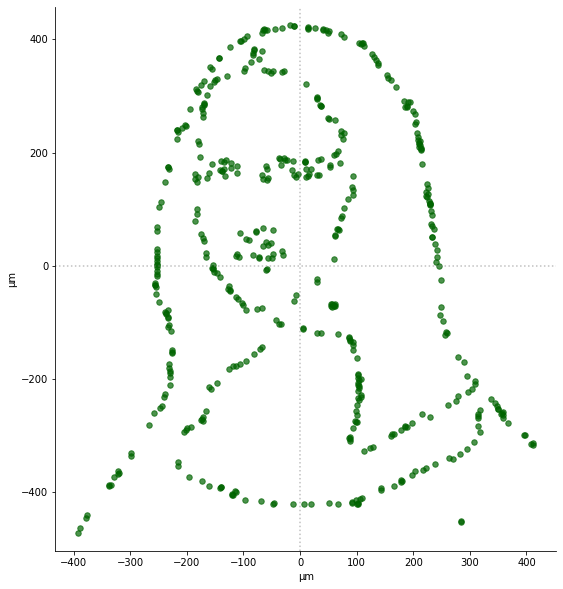

In [1]:
from pulser import Register
from pulser.devices import Chadoq2
import numpy as np

qubits = np.loadtxt("files/ml_coords")
ml_reg = Register.from_coordinates(qubits)
ml_reg.rotate(90)
ml_reg.draw(with_labels=False)

It is also simple to create and design **Pulses** that will act on the atom array:

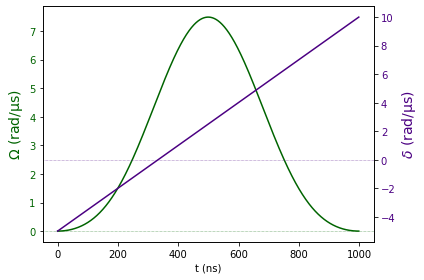

In [2]:
from pulser import Pulse
from pulser.waveforms import RampWaveform, BlackmanWaveform

duration = 1000 # Typical: ~1 µsec
pulse = Pulse(BlackmanWaveform(duration, np.pi), RampWaveform(duration, -5., 10.), 0)
pulse.draw()

Each pulse acts on a set of atoms at a certain moment of time. The entire **Sequence** is stored by Pulser and can then be either simulated or sent to a real device. Below is the example of a sequence sending the same $\pi$-pulse to two atoms, sequentially, using the same channel.

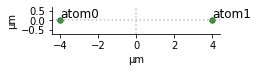

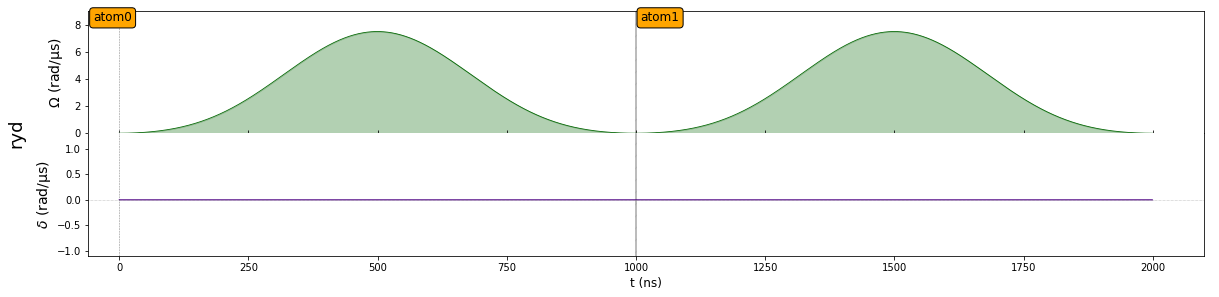

In [4]:
from pulser import Sequence

reg = Register.rectangle(1, 2, spacing=8, prefix='atom')
reg.draw()

pi_pulse = Pulse.ConstantDetuning(BlackmanWaveform(duration, np.pi), 0., 0.)

seq = Sequence(reg, Chadoq2)

seq.declare_channel('ryd','rydberg_local','atom0')

seq.add(pi_pulse,'ryd')
seq.target('atom1', 'ryd')
seq.add(pi_pulse,'ryd')

seq.draw()

## Probing the Rydberg Blockade Mechanism

Rydberg atoms are a prominent architecture for exploring condensed matter physics and quantum information processing. For example, one can use Pulser to write a sequence of succesive $\pi$-pulses on a two atom system, each one coupling the atom to its excited Rydberg state. This will allow us to study the *Rydberg Blockade* effect, using Pulser's **Simulation** library:

The presence of the van der Waals interaction when both atoms are in the Rydberg state, prevents the collective ground state $|gg\rangle$ to couple to $|rr\rangle$, which is shifted out of resonance. 

The Hamiltonian for the two-atom system can be written as:

$$H = \frac{\hbar \Omega_1(t)}{2} \sigma_1^x + \frac{\hbar \Omega_2(t)}{2} \sigma_2^x + U n_1n_2 $$

We shall explore this blockade by changing the interatomic distance $R$:

In [5]:
import matplotlib.pyplot as plt
from pulser.simulation import Simulation

data = []
distances = np.linspace(6.5, 14, 7)

r = [1,0] # |r>
rr = np.kron(r,r) # |rr>
occup = [np.outer(rr, np.conj(rr))]  # |rr><rr|

# Atom Register
reg = Register.rectangle(1,2,spacing=R, prefix='atom')

for i,R in enumerate(distances):
    # Pulse Sequence
    seq = Sequence(reg, Chadoq2)
    seq.declare_channel('ryd','rydberg_local','atom0')
    seq.add(pi_pulse,'ryd')
    seq.target('atom1', 'ryd')
    seq.add(pi_pulse,'ryd')

    sim = Simulation(seq)
    
    res = sim.run()  # Returns a SimulationResults instance
    data.append(res.expect(occup)[0]) # Get expectation value for the occupation operator
print("...Simulation Complete!")

...Simulation Complete!


We plot the results

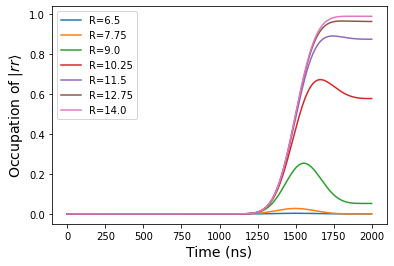

In [6]:
for i,R in enumerate(distances):
    plt.plot(data[i], label=f'R={R}')
    plt.xlabel('Time (ns)', fontsize=14)
    plt.ylabel(r'Occupation of $|rr\rangle$', fontsize=14)
    plt.legend()

Notice how the occupation of $|rr\rangle$ is suppressed for decreasing $R$. This means that, up until a certain distance between the two atoms (called the *Rydberg blockade radius*), the fact that `atom0` was first excited to the Rydberg state prevents `atom1` from being excited to the same state with the same pulse, i.e. `atom0` **blockades the excitation of** `atom1` to the Rydberg state.

This conditional excitation of one atom depending on the state of another closely resembles that of a controlled gate in a quantum circuit. In fact, for neutral atom devices, the **Rydberg blockade mechanism is the key behind entanglement generation between atoms**.

You can find many more details about Pulser, its features and the neutral atom device architecture in this documentation and in the Tutorials.